ID: A1809
<br>
Date of Submission : 30-03-19

# Entrance Challenge: When Will the Sakura Bloom?

Importing Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import warnings
from copy import deepcopy
warnings.filterwarnings('ignore')

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

In [2]:
sakura = pd.read_csv("tokyo.csv") 
BloomDate = pd.read_csv("BloomDate.csv")
sakura.rename(columns = lambda x: x.replace(' ', '_').lower(), inplace=True)
BloomDate.rename(columns = lambda x: x.replace(' ', '_').lower(), inplace=True)

***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

Tmean =  638.3557692307693


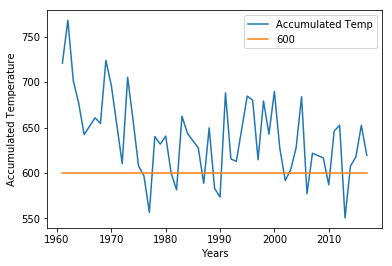

In [63]:
train = pd.read_csv("train.csv")
year_wise_accumulated_temp = []
years = train["year"].unique()
for year in years:
    add = 0
    df = train.loc[(train["year"]==year) & (train["month"]!=1)]
    
    
        
    for row,bl in df.iterrows():
        if bl['year'] not in [1966, 1971, 1985, 1994, 2008]:
            temp_add = (df.loc[row,"highest_temp"])# + df.loc[row,"lowest_temp"])/2
            #if temp_add>600:
            #   temp_add-=600
            #  print("hello")
            add+=temp_add
            if bl["bloom"] == 1:
                break
    year_wise_accumulated_temp.append(add)
    #print(year,add)
    
Tmean = np.mean(year_wise_accumulated_temp)
print("Tmean = ",Tmean)
plt.plot(years,year_wise_accumulated_temp,label = "Accumulated Temp")
plt.plot(years,[600 for i in range(len(years))],label = "600")
#plt.plot(years,[600 for i in range(len(years))],"b",label="600 Degree")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Accumulated Temperature")
plt.show()
# As the Tmean value is around 600 and from the plot it is clear that maximum year wise accumulated temparature 
# is around 600 so it can be used as a rule for Tokyo.


### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [66]:
rule_based_threshold = 600
test = pd.read_csv("test.csv")
actual = test[test["bloom"]==1]
years = actual["year"]
predicted = []
predicted_600 = []
#print(years)

#calculating leap years 

def is_leap_year(year):
    """ if year is a leap year return True
        else return False """
    if year % 100 == 0:
        return year % 400 == 0
    return year % 4 == 0

#converting date of year

def doy(Y,M,D):
    """ given year, month, day return day of year
        Astronomical Algorithms, Jean Meeus, 2d ed, 1998, chap 7 """
    if is_leap_year(Y):
        K = 1
    else:
        K = 2
    N = int((275 * M) / 9.0) - K * int((M + 9) / 12.0) + D - 30
    return N

for year in years:
    add=0
    df = test.loc[(test["year"]==year) & (test["month"]!=1)]
    for row,bl in df.iterrows():
            add+=df.loc[row,"highest_temp"]
            if add>Tmean:
                conv_day = doy(bl["year"],bl["month"],bl["day"])
                print("Blooming Day", conv_day)
                predicted.append(conv_day)
                break

#for 600
for year in years:
    add=0
    df = test.loc[(test["year"]==year) & (test["month"]!=1)]
    for row,bl in df.iterrows():
            add+=df.loc[row,"highest_temp"]
            if add>rule_based_threshold:
                conv_day = doy(bl["year"],bl["month"],bl["day"])
                predicted_600.append(conv_day)
                break

                
actual_val = []
for row,bl in actual.iterrows():
    conv_day = doy(bl["year"],bl["month"],bl["day"])
    actual_val.append(conv_day)
    
    
actualValueForTmean=deepcopy(actual_val)
predictedValueForTmean=deepcopy(predicted)

#for 638
print("R2 score for 638 degree: ", r2_score(actual_val,predicted))
#for 600
print("R2 score for 600 degree: ", r2_score(actual_val,predicted_600))



print('Actual: ',actual_val)
print('Predicted for Tmean', predicted)
print('Predicted for 600', predicted_600)

Blooming Day 82.0
Blooming Day 88.0
Blooming Day 91.0
Blooming Day 90.0
Blooming Day 85.0
R2 score for 638 degree:  0.8323615160349854
R2 score for 600 degree:  0.6793002915451896
Actual:  [79.0, 89.0, 93.0, 90.0, 82.0]
Predicted for Tmean [82.0, 88.0, 91.0, 90.0, 85.0]
Predicted for 600 [79.0, 86.0, 88.0, 87.0, 83.0]


 The R squared value for Tmean is much better than just using 600 as threshold. So it seems Tmean works better for this particular test years. Now we should try it for other test years as well. After that we can give some opinions.

***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

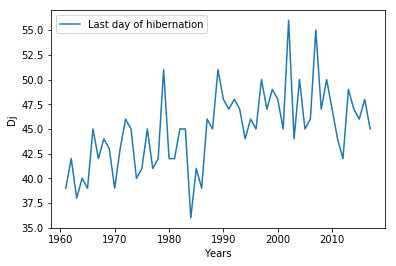

[39.0, 42.0, 38.0, 40.0, 39.0, 45.0, 42.0, 44.0, 43.0, 39.0, 43.0, 46.0, 45.0, 40.0, 41.0, 45.0, 41.0, 42.0, 51.0, 42.0, 42.0, 45.0, 45.0, 36.0, 41.0, 39.0, 46.0, 45.0, 51.0, 48.0, 47.0, 48.0, 47.0, 44.0, 46.0, 45.0, 50.0, 47.0, 49.0, 48.0, 45.0, 56.0, 44.0, 50.0, 45.0, 46.0, 55.0, 47.0, 50.0, 47.0, 44.0, 42.0, 49.0, 47.0, 46.0, 48.0, 45.0]


In [53]:
#given from equation 
latitude = 35 + 40/60

L = 4

all_data = pd.read_csv("tokyo.csv")

years = all_data["year"].unique()

Dj = []
all_yearly_Dj = []

for year in years:

    df = all_data.loc[(all_data["year"]==year) & (all_data["month"]<4)]
    #temparature
    Tf = np.mean(df["avg_temp"])
    #from equation
    dj = 136.75 - (7.689*latitude) + (0.133*(latitude**2)) - (1.307*np.log(L)) + (0.144*Tf) + (0.285*(Tf**2))
    #Dj.append(dj)
    Dj.append(np.round(dj))
    all_yearly_Dj.append((years,(np.round(Dj))))

#plotting the values 
plt.plot(years,Dj,label = "Last day of hibernation")
plt.legend()
plt.xlabel("Years")
plt.ylabel("Dj")
plt.show()
print(Dj)

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


[38.910184020356446, 37.31596443870652, 39.57567169706983, 39.14795314917655, 38.855371519892174, 36.11973376156855, 34.73758126501, 40.369822603724316, 42.69855423700818, 32.47083194742553, 34.860776040521294, 38.896422279684735, 34.74045251977132, 29.363254220272953, 30.762719375903394, 36.15117510425791, 24.777359926237015, 37.02893416914124, 32.95157690169447, 29.41851341148468, 34.57189350047144, 46.815734097396664, 39.966767584366096, 27.617626831133055, 36.197550275950945, 22.58516028670156, 26.109897001428315, 33.31944824241389, 28.56923901843935, 28.071550455613522, 34.465473439213774, 35.712531495723745, 24.612551409424395, 30.926062178890543, 27.73561573690964, 32.61584510677082, 29.595479349578607, 16.77848712880796, 32.12973490354575, 23.52327690926109, 35.09726050176687, 27.304508706050868, 19.513846182709496, 24.292070264561524, 27.7434494765644, 33.15192599425089, 37.492503716379666, 21.21114574730047, 29.31467578085902, 28.558615193232747, 26.503728809845036, 27.516722

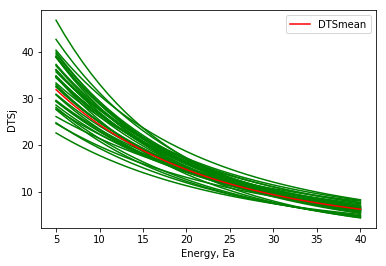

In [67]:
train_data = pd.read_csv("train.csv")
years = train_data["year"].unique()
DTSj = []
DTSNewForTest=[]
dayCount=0
R = (8.314 * 10 ** -3)/4.184
Ts=17 + 273.15 #converting to kelvin
for Ea in range(5,41,1):
        
        for year in years:
            df = train_data.loc[(train_data["year"]==year)]
            df.reset_index(inplace=True)
            add=0
            dayCount=0
            row = Dj[year-1961]
            for index,r in df.iterrows():
                dayCount+=1
                if dayCount>=row:
                    Tij = (273.15 + r['avg_temp'])
                    add+= np.exp(((Tij-Ts)*Ea)/(R*Tij*Ts))
                    if r['bloom']==1:
                        DTSj.append(add)
                        break
print(DTSj)
DTSmean=[]    
for i in range(0,len(DTSj),52):
        c = DTSj[i:i+52]
        DTSmean.append(np.average(c))
#DTSmean.append(c/len(years))
    
for idx in range(0,37):
    g = [DTSj[idx] for idx in range(idx,len(DTSj),52)]
    plt.plot([x for x in range(5,41)],g,color="g")
    plt.xlabel("Energy, Ea")
    plt.ylabel("DTSj")

plt.plot([x for x in range(5,41)],DTSmean,label = "DTSmean",color="r")
plt.legend()
plt.show()

In [83]:
print(trainDf)

[[0.7063304  0.70683079 0.00146251 0.00380824 0.03810557 0.00435117]
 [0.70635824 0.70685776 0.0009269  0.00436612 0.03699839 0.00461898]
 [0.7062753  0.70677508 0.0023524  0.00399443 0.04011978 0.00362131]
 [0.70507969 0.70816283 0.0007991  0.00373872 0.03647169 0.00481945]
 [0.70508043 0.70816376 0.00112761 0.00441216 0.03643647 0.00416218]
 [0.70515163 0.70822705 0.00116249 0.00470674 0.03364698 0.00447271]
 [0.70497209 0.70805397 0.00213385 0.00448844 0.04047727 0.00329023]
 [0.70512345 0.70821216 0.00108097 0.00372102 0.03469957 0.00416813]
 [0.70499394 0.70806682 0.00229394 0.00499382 0.03976673 0.00365116]
 [0.70510936 0.708201   0.00156132 0.00390601 0.0351626  0.00424617]
 [0.70507787 0.70816808 0.00194399 0.004127   0.03639642 0.0042015 ]
 [0.70505221 0.7081249  0.00165128 0.00490711 0.03766153 0.00391327]
 [0.70507852 0.70817095 0.00165183 0.00412144 0.03638661 0.00380655]
 [0.7051117  0.70819071 0.00136318 0.00435519 0.03531069 0.0039676 ]
 [0.70505706 0.70812225 0.00191622

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

[56.30769230769231, 51.42307692307692, 46.51923076923077, 42.13461538461539, 38.21153846153846, 34.5, 31.865384615384617, 28.134615384615383, 25.75, 23.48076923076923, 21.48076923076923, 19.03846153846154, 17.01923076923077, 15.788461538461538, 14.711538461538462, 14.076923076923077, 13.01923076923077, 12.576923076923077, 11.942307692307692, 11.326923076923077, 10.884615384615385, 10.307692307692308, 10.365384615384615, 10.76923076923077, 10.423076923076923, 10.634615384615385, 10.692307692307692, 10.98076923076923, 11.192307692307692, 11.653846153846153, 12.442307692307692, 12.615384615384615, 13.288461538461538, 11.450980392156863, 12.156862745098039, 13.156862745098039]
Minimum Error:  10.307692307692308
Optimal Ea:  26


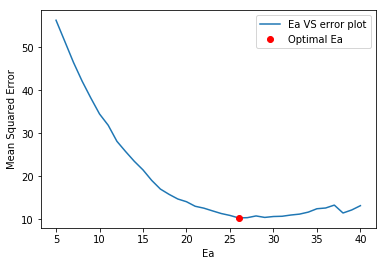

In [8]:
def mean_squared(y,predicted):
    sq_diff = np.square(np.subtract(y,predicted))
    err = np.sum(sq_diff)
    return err/len(y)

years = train_data["year"].unique()
error = []

for d in DTSmean:
    prediction = []
    actual = []
    dtsmean = np.round(d)
    for year in years:
        df = train_data.loc[(train_data["year"]==year)]
        df.reset_index(inplace=True)
        row = Dj[year-1961]
        counter = 0
        selected_df = df.loc[row:,:]
        for u,val in selected_df.iterrows():
            Eatemp=(DTSmean.index(d)+5)
            Tij = val["avg_temp"]+273.15
            ts = np.exp((Eatemp*(Tij-Ts))/(R*Tij*Ts))
            counter+=ts
            if counter>=d:
                prediction.append(doy(val["year"],val["month"],val["day"]))
                act=selected_df.loc[(selected_df["bloom"]==1)]
                actual.append(doy(int(act["year"]),int(act["month"]),int(act["day"])))
                break
    error.append(mean_squared_error(actual, prediction))

print(error)
x_values = [x for x in range(5,41)]
plt.plot(x_values,error,label = "Ea VS error plot")
min_error = min(error)
idx = error.index(min_error)+5 # since the index starts from 0 but Ea value starts from 5

print("Minimum Error: ",min_error)
print("Optimal Ea: ",idx)
plt.plot(idx,min_error,"ro",label = "Optimal Ea")
plt.legend()
plt.xlabel("Ea")
plt.ylabel("Mean Squared Error")
plt.show()



### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [24]:
test_data = pd.read_csv("test.csv")
years = test_data["year"].unique()
Ea = 26
dtsmean = np.round(DTSmean[Ea-5])

prediction = []
actual = []

for year in years:
    df = test_data.loc[(test_data["year"]==year)]
    df.reset_index(inplace=True)
    row = Dj[year-1961]
    counter = 0
    selected_df = df.loc[row:,:]
    for u,val in selected_df.iterrows():
        Tij = val["avg_temp"]+273.15
        ts = np.exp((Ea*(Tij-Ts))/(R*Tij*Ts))
        counter+=ts
        if counter>=dtsmean:
            prediction.append(int(doy(val["year"],val["month"],val["day"])))
            
            act=selected_df.loc[(selected_df["bloom"]==1)]
            actual.append(doy(int(act["year"]),int(act["month"]),int(act["day"])))
            break

actualValueForDTS=actual
predictedValueForDTS=predicted
print(actual)
print(prediction)
print(r2_score(actual,prediction))

[79, 89, 93, 90, 82]
[80, 88, 91, 90, 83]
0.9489795918367347


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1.According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.



2.There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.

In the above proposed model we use only the temperature records of the past 61 years. However blooming date sakura depnds on many other things as well like the rain fall and humidity of the year. So if we include those as a feature there is a chance that the accuracy may increase. There is no mathmatical formula yet to include all these parameters as feature so machine learning approach could help us in this. We can try some popular ML algorithms to see what happens. 


***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

In [12]:
fullDf = pd.read_csv('tokyo.csv')
years=fullDf['year'].unique()
#assuming the data for the first 3 months can be acquired or predicted
JanToMar=(fullDf['month']>=1) & (fullDf['month']<=3)

#calculate the bloom dates of all years
bloom=(fullDf['bloom']==1)
bloomDateDf=fullDf[bloom]


#when it will bloom starting from day 1 from a  year
bloom=[]
for index,row in bloomDateDf.iterrows():
    bloomDate=(dt.date(int(row['year']),int(row['month']),int(row['day'])) - dt.date(int(row['year']),1,1)).days+1
    bloom.append(bloomDate)
    
#split train,test and validation data    
trainYear = (fullDf['year']!=1966) & (fullDf['year']!=1971) & (fullDf['year']!=1985) & (fullDf['year']!=1994) & (fullDf['year']!=2008)
testYear=(fullDf['year']==1966) | (fullDf['year']==1971) | (fullDf['year']==1985) | (fullDf['year']==1994) | (fullDf['year']==2008)

#print(trainYear)
#print(testYear)

trainDf=fullDf[trainYear & JanToMar]
testDf=fullDf[testYear & JanToMar]


trainDf=trainDf.reset_index(drop=True)
testDf=testDf.reset_index(drop=True)  


#keeping year,local_avg, sea_level, total_rainfall,avg_temp,avg_hum,sunshine_time,bloom
trainDf=trainDf.drop(["bloom","serial","month","day","max_rain_1_day","max_rain_10_min","highest_temp","lowest_temp","lowest_hum"], axis=1)
testDf=testDf.drop(["bloom","serial","month","day","max_rain_1_day","max_rain_10_min","highest_temp","lowest_temp","lowest_hum"], axis=1)


#validation years=1963,1973,1983,1993,2003 - manual arbitrary selection
selectedTrainYear = (trainDf['year']!=1963) & (trainDf['year']!=1973) & (trainDf['year']!=1983) & (trainDf['year']!=1993) & (trainDf['year']!=2003)
validYear=(trainDf['year']==1963) | (trainDf['year']==1973) | (trainDf['year']==1983) | (trainDf['year']==1993) | (trainDf['year']==2003)
validationDf=trainDf[validYear]
trainDf=trainDf[selectedTrainYear]

trainDf=trainDf.reset_index(drop=True)
validationDf=validationDf.reset_index(drop=True)  

#sum of all features for each year
trainDf=trainDf.groupby('year').sum().reset_index()
testDf=testDf.groupby('year').sum().reset_index()
validationDf=validationDf.groupby('year').sum().reset_index()

trainDf=trainDf.drop(["year"], axis=1)
testDf=testDf.drop(["year"], axis=1)
validationDf=validationDf.drop(["year"], axis=1)

#normalization for equal effect of all features
trainDf=normalize(trainDf)
testDf=normalize(testDf)
validationDf=normalize(validationDf)

 
y_train=[]
y_valid=[]
y_test=[]
i=0
for i in range(len(bloom)):
    if i in [1966-1961,1971-1961,1985-1961,1994-1961,2008-1961]:
        y_test.append(bloom[i])
    elif i in [1963-1961,1973-1961,1983-1961,1993-1961,2003-1961]:
        y_valid.append(bloom[i])
    else:
        y_train.append(bloom[i])
#print(y_train)       
#print (y_valid)
accuracyList=[]
maxAccuracy=0
predictionList=[]
for i in range(100):
    
    clf = MLPRegressor(hidden_layer_sizes=(7),activation="relu",solver="lbfgs",max_iter=5000)
    
    clf.fit(trainDf,y_train)
    accuracy=clf.score(validationDf,y_valid)
    if accuracy>maxAccuracy:
        maxAccuracy=accuracy
        #print(maxAccuracy)
        bestClf=clf
    accuracyList.append(accuracy)
accuracy=bestClf.score(testDf,y_test)
predictionList=bestClf.predict(testDf)
#print (predictionList)
print("Accuracy: ",accuracy)

actualValueForNN=y_test
predictedValueForNN=predictionList

Accuracy:  0.5361472282817926


In [85]:
trainDf.shape

(47, 6)

### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

R squared for Tmean:  0.8323615160349854
R squared for DTS:  0.8323615160349854
R squared for NN:  0.5361472282817926


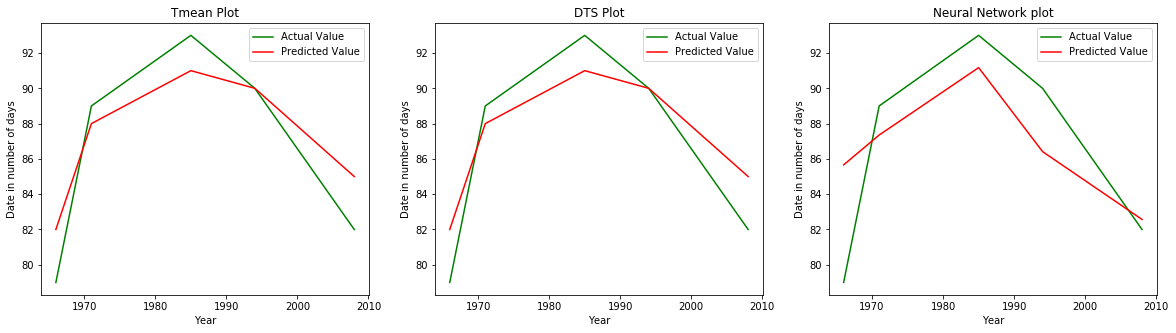

In [25]:
r2sTmean= r2_score(actualValueForTmean,predictedValueForTmean)

r2sDTS= r2_score(actualValueForDTS,predictedValueForDTS)

r2sNN= r2_score(actualValueForNN,predictedValueForNN)

testYears=[1966,1971,1985,1994,2008]
print("R squared for Tmean: ",r2sTmean)
print("R squared for DTS: ",r2sDTS)
print("R squared for NN: ",r2sNN)

plt.figure(figsize = (20,5))
plt.subplot(131)

plt.plot(testYears,actualValueForTmean,color='g',label="Actual Value")
plt.plot(testYears,predictedValueForTmean,color='r',label="Predicted Value")
plt.ylabel("Date in number of days")
plt.xlabel("Year")
plt.title("Tmean Plot")
plt.legend()

plt.subplot(132)

plt.plot(testYears,actualValueForDTS,color='g',label="Actual Value")
plt.plot(testYears,predictedValueForDTS,color='r',label="Predicted Value")
plt.ylabel("Date in number of days")
plt.xlabel("Year")
plt.title("DTS Plot")
plt.legend()

plt.subplot(133)

plt.plot(testYears,actualValueForNN,color='g',label="Actual Value")
plt.plot(testYears,predictedValueForNN,color='r',label="Predicted Value")
plt.ylabel("Date in number of days")
plt.xlabel("Year")
plt.title("Neural Network plot")
plt.legend()
plt.show()

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

In [44]:
BloomDate

,serial,year,month,day
0,0,1961,1,1
1,1,1961,1,2
2,2,1961,1,3
3,3,1961,1,4
4,4,1961,1,5
5,5,1961,1,6
6,6,1961,1,7
7,7,1961,1,8
8,8,1961,1,9
9,9,1961,1,10


In [42]:
print(b_dates_)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [43]:
print(years_)

[1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 196

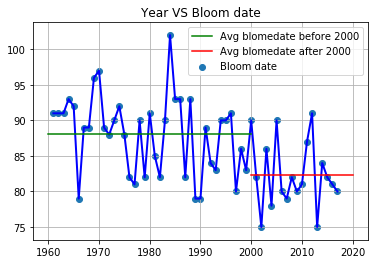

In [46]:
years_ = []
b_dates_ = []
for index,row in bloomDateDf.iterrows():
    year = int(row["year"])
    years_.append(year)
    month = int(row["month"])
    date = int(row["day"])
    nth_day_in_the_year = (dt.date(year, month, date) - dt.date(year,1,1)).days + 1
    b_dates_.append(nth_day_in_the_year)
index_of_2000 = years_.index(2000)

plt.plot(years_, b_dates_, color='blue', linewidth=2)
plt.scatter(years_,b_dates_,label="Bloom date")
plt.plot([x for x in range(1960,2001)],[np.average(b_dates_[:index_of_2000]) for y in range(41)],color='green',label="Avg blomedate before 2000")
plt.plot([x for x in range(2000,2021)],[np.average(b_dates_[index_of_2000:]) for y in range(21)],color='r',label="Avg blomedate after 2000")
plt.title('Year VS Bloom date')
plt.grid(True)
plt.legend()
plt.show()


**From the above graph we can see that,sakura started to bloom earlier from the previous years.**

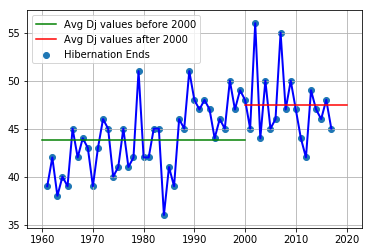

In [50]:
plt.plot(years_,Dj,color='blue', linewidth=2)
plt.scatter(years_,Dj,label="Hibernation Ends")
plt.plot([x for x in range(1960,2001)],[np.average(Dj[:index_of_2000]) for y in range(41)],color='green',label="Avg Dj values before 2000")
plt.plot([x for x in range(2000,2021)],[np.average(Dj[index_of_2000:]) for y in range(21)],color='r',label="Avg Dj values after 2000")
plt.grid(True)
plt.legend()
plt.show()

**sakura need more days to woke up from hibernation from the previous years**
**so we can see sakura have a large hibernation time then before but blooms earlier.<br>
so it is clear that sakura adapeded itself to bloom in less temperature then before.**